# **Importing necessary libraries**

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_cv
import cv2
import random
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend


# **Setting random seed**

In [ ]:
seed=1234
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(seed)

Random seed set as 1234


# **Preparing dataset**

In [ ]:
dataset= tfds.load('oxford_iiit_pet',split='train+test',shuffle_files=True)
ds_numpy=np.vstack(tfds.as_numpy(dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2HAFCF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2HAFCF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [ ]:
X=np.array(list(map(lambda x:x[0]['image'],ds_numpy)))
y=np.array(list(map(lambda x:x[0]['label'],ds_numpy)))
print(X.shape)
print(y.shape)

(7349,)
(7349,)


In [ ]:
img_size=128
n=X.shape[0]
X_=np.zeros(shape=(n,img_size,img_size,3),dtype='uint8')
i=0
for img in X:
    img=cv2.resize(img,(img_size,img_size))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X_[i]=img
    i+=1

# **Visualizing some images from the dataset**

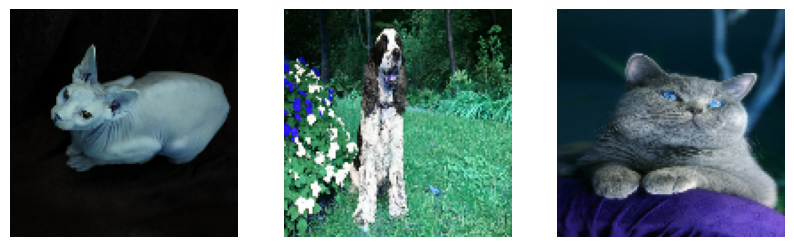

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,3,1)
ax.axis('off')
ax.imshow(X_[0])
ax=fig.add_subplot(1,3,2)
ax.axis('off')
ax.imshow(X_[1])
ax=fig.add_subplot(1,3,3)
ax.axis('off')
ax.imshow(X_[2])
plt.show()

# **Transforming dataset to tensor**

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_,y,random_state=1,train_size=0.95)
X_train_l,X_train_u,y_train_l,y_train_u=train_test_split(X_train,y_train,random_state=1,train_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_train_l.shape)
print(y_train_l.shape)
print(X_train_u.shape)
print(y_train_u.shape)
print(X_val.shape)
print(y_val.shape)

(6981, 128, 128, 3)
(6981,)
(2094, 128, 128, 3)
(2094,)
(4887, 128, 128, 3)
(4887,)
(368, 128, 128, 3)
(368,)


In [ ]:
BATCH_SIZE=128
X_train=tf.convert_to_tensor(X_train)
print(X_train.shape)
y_train=tf.convert_to_tensor(y_train)
print(y_train.shape)
X_val=tf.convert_to_tensor(X_val)
print(X_val.shape)
y_val=tf.convert_to_tensor(y_val)
print(y_val.shape)
X_train_l=tf.convert_to_tensor(X_train_l)
print(X_train_l.shape)
y_train_l=tf.convert_to_tensor(y_train_l)
print(y_train_l.shape)
X_train_u=tf.convert_to_tensor(X_train_u)
print(X_train_u.shape)
y_train_u=tf.convert_to_tensor(y_train_u)
print(y_train_u.shape)
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE)
train_labeled_data=tf.data.Dataset.from_tensor_slices((X_train_l,y_train_l)).batch(BATCH_SIZE)
train_unlabeled_data=tf.data.Dataset.from_tensor_slices((X_train_u,y_train_u)).batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)

(6981, 128, 128, 3)
(6981,)
(368, 128, 128, 3)
(368,)
(2094, 128, 128, 3)
(2094,)
(4887, 128, 128, 3)
(4887,)


# **Learning base model(on a complete train sample) and it`s evaluation**

In [ ]:
EPOCHS=15
base_model=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=37,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1(0.1))])
model.summary()
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model.fit(train_data,validation_data=val_data,epochs=EPOCHS)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 37)                303141    
                                                                 
Total params: 15,017,829
Trainable params: 303,141
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
55/55 [==============================] - 29s 409ms/step - loss: 409.3952 - Accuracy: 0.1126 - val_loss: 357.8687 - val_Accuracy: 0.2174
Epoch 2/15
55/55 [==============================] - 22s 405ms/step - loss: 319.2411 - Accu

In [ ]:
model.evaluate(val_data)

3/3 [==============================] - 0s 124ms/step - loss: 14.4984 - Accuracy: 0.6141


[14.498407363891602, 0.614130437374115]

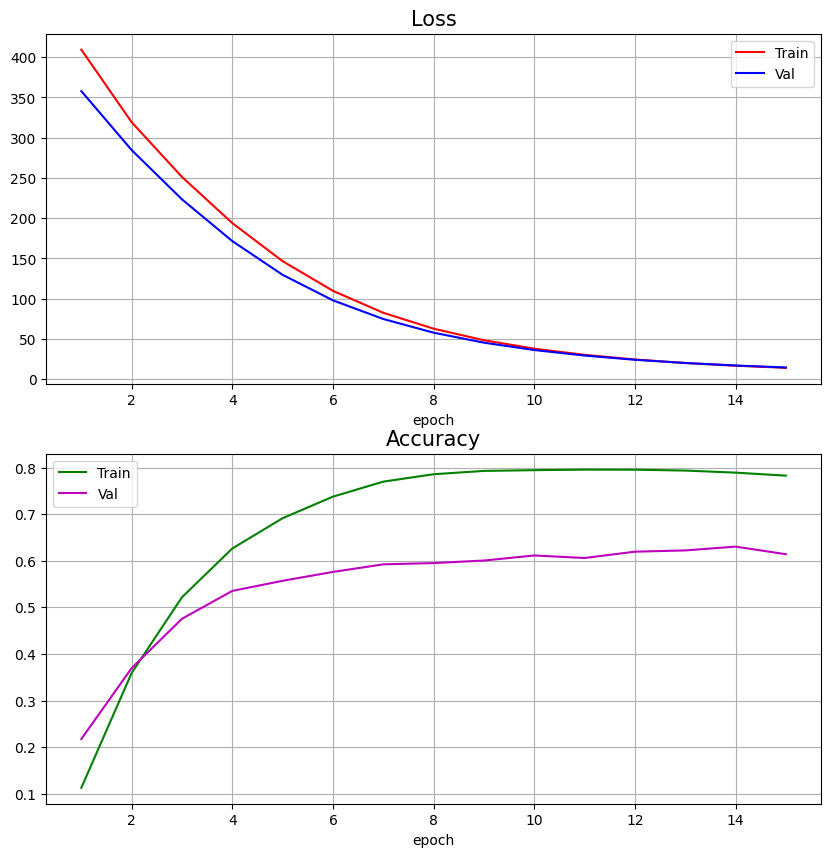

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
model.save_weights('/kaggle/working/weights_1.h5')

# **Noisy Student algorithm realisation**

# **Learning teacher-model(on small dataset of labeled data), it's analysis and saving model's weights**

In [ ]:
EPOCHS=15
teacher_model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=37,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1(0.1))])
teacher_model.summary()
teacher_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=teacher_model.fit(train_labeled_data,validation_data=val_data,epochs=EPOCHS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 37)                303141    
                                                                 
Total params: 15,017,829
Trainable params: 303,141
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
17/17 [==============================] - 7s 415ms/step - loss: 449.1816 - Accuracy: 0.0435 - val_loss: 427.0888 - val_Accuracy: 0.0707
Epoch 2/15
17/17 [==============================] - 7s 409ms/step - loss: 405.7004 - Accuracy: 0.1375 - val_loss: 392.8200 - val_Accuracy: 0.1304
Epoch 3/

In [ ]:
teacher_model.evaluate(val_data)

3/3 [==============================] - 0s 123ms/step - loss: 129.7314 - Accuracy: 0.4130


[129.73143005371094, 0.41304346919059753]

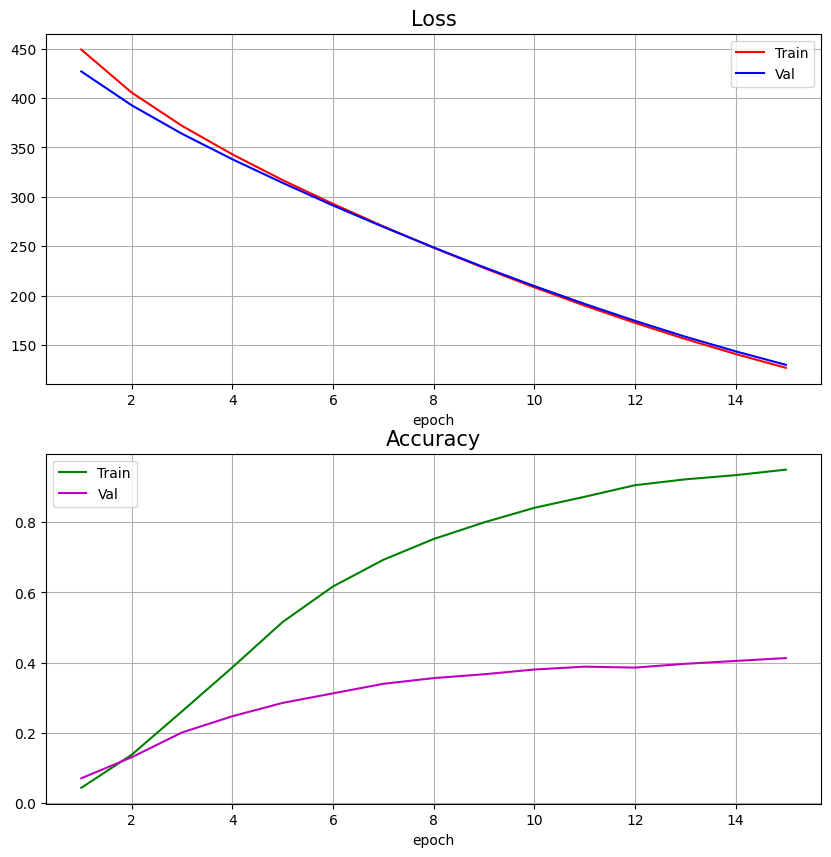

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

# **Pseudo-labeling and combining labeled and unlabeled data in one sample**

In [ ]:
pseudo_labels=teacher_model.predict(X_train_u)
pseudo_labels=np.array([np.argmax(x) for x in pseudo_labels])
print(pseudo_labels)

153/153 [==============================] - 5s 30ms/step
[10 17 28 ...  4 33  8]


In [ ]:
combined_data=np.concatenate([X_train_l,X_train_u],axis=0)
print(combined_data.shape)
combined_labels=np.concatenate([y_train_l,pseudo_labels],axis=0)
print(combined_labels.shape)

(6981, 128, 128, 3)
(6981,)


# **Adding noise to data**

In [ ]:
Rand_Augment=tf.keras.Sequential([tf.keras.layers.Input(shape=(img_size,img_size,3)),
                                  keras_cv.layers.RandAugment(value_range=(0, 255),magnitude=0.1)])

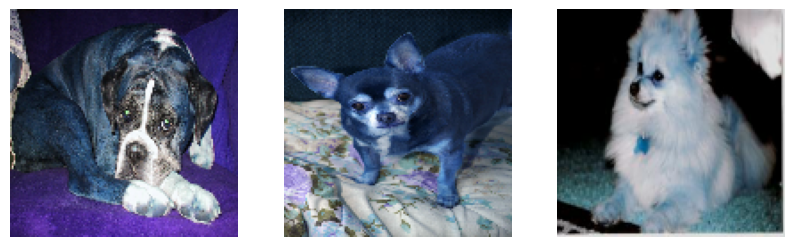

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.axis('off')
    ax.imshow(combined_data[i])
plt.show()

In [ ]:
combined_noised_data=Rand_Augment.predict(combined_data)

219/219 [==============================] - 27s 111ms/step


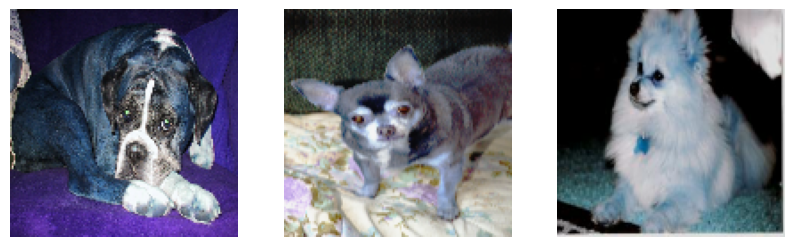

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.axis('off')
    aug_img = combined_noised_data[i]
    ax.imshow(aug_img.astype('int'))
plt.show()

# **Learning student-model, and it`s evaluation**

In [ ]:
EPOCHS=15
student_model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dropout(0.25),
                           tf.keras.layers.Dense(units=37,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1(0.1))])
student_model.summary()
student_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=student_model.fit(train_labeled_data,validation_data=val_data,epochs=EPOCHS)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 37)                303141    
                                                                 
Total params: 15,017,829
Trainable params: 303,141
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
17/17 [==============================] - 7s 411ms/step - loss: 461.4257 - Accuracy: 0.0339 - val_loss: 428.1191 - val_Accuracy: 0.0516
Epoch 2/15
17/17 [====

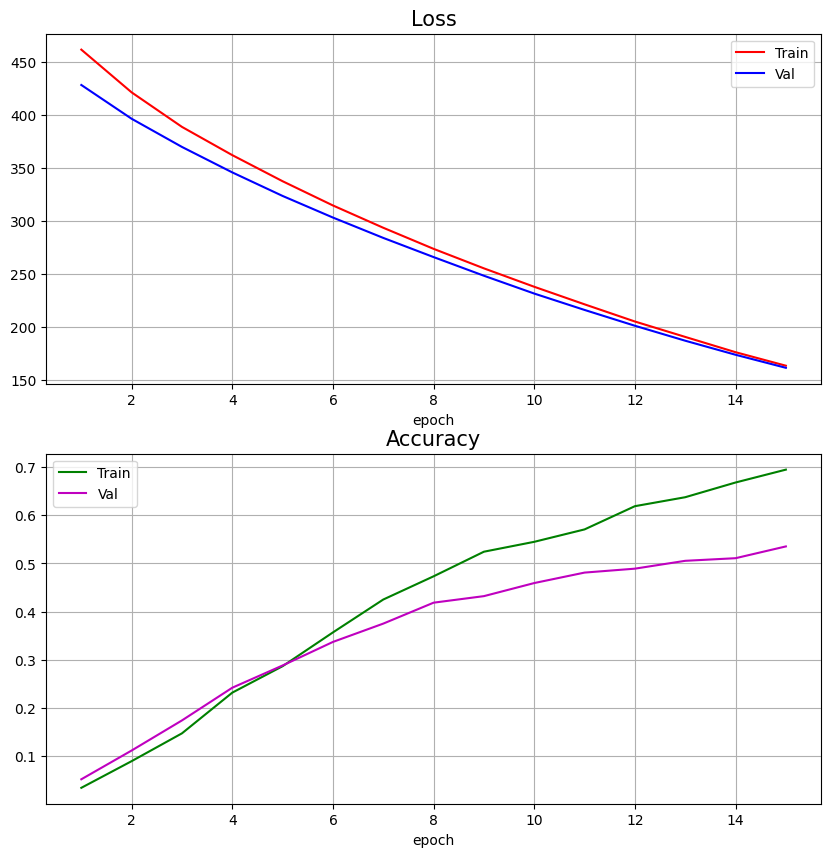

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
student_model.evaluate(val_data)

3/3 [==============================] - 0s 124ms/step - loss: 161.6517 - Accuracy: 0.5353


[161.65174865722656, 0.5353260636329651]

# **Saving weights of student-model**

In [ ]:
student_model.save_weights('/kaggle/working/weights_2.h5')